In [1]:
import numpy as np
import jdc
import tensorflow as tf
from distutils.version import StrictVersion

from maci.misc import logger
from maci.misc.overrides import overrides
from maci.misc import tf_utils

from maci.learners.base import MARLAlgorithm

EPS = 1e-6

/home/siphelele/anaconda3/envs/masql/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/siphelele/anaconda3/envs/masql/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/siphelele/anaconda3/envs/masql/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/siphelele/anaconda3/envs/masql/lib

In [2]:
def adaptive_isotropic_gaussian_kernel(xs, ys, h_min=1e-3):
    """Gaussian kernel with dynamic bandwidth.
    The bandwidth is adjusted dynamically to match median_distance / log(Kx).
    See [2] for more information.
    Args:
        xs(`tf.Tensor`): A tensor of shape (N x Kx x D) containing N sets of Kx
            particles of dimension D. This is the first kernel argument.
        ys(`tf.Tensor`): A tensor of shape (N x Ky x D) containing N sets of Kx
            particles of dimension D. This is the second kernel argument.
        h_min(`float`): Minimum bandwidth.
    Returns:
        `dict`: Returned dictionary has two fields:
            'output': A `tf.Tensor` object of shape (N x Kx x Ky) representing
                the kernel matrix for inputs `xs` and `ys`.
            'gradient': A 'tf.Tensor` object of shape (N x Kx x Ky x D)
                representing the gradient of the kernel with respect to `xs`.
    Reference:
        [2] Qiang Liu,Dilin Wang, "Stein Variational Gradient Descent: A General
            Purpose Bayesian Inference Algorithm," Neural Information Processing
            Systems (NIPS), 2016.
    """
    Kx, D = xs.get_shape().as_list()[-2:]
    Ky, D2 = ys.get_shape().as_list()[-2:]
    assert D == D2

    leading_shape = tf.shape(xs)[:-2]

    # Compute the pairwise distances of left and right particles.
    diff = tf.expand_dims(xs, -2) - tf.expand_dims(ys, -3)
    # ... x Kx x Ky x D

    if StrictVersion(tf.__version__) < StrictVersion('1.5.0'):
        dist_sq = tf.reduce_sum(diff**2, axis=-1, keep_dims=False)
    else:
        dist_sq = tf.reduce_sum(diff**2, axis=-1, keepdims=False)
    # ... x Kx x Ky

    # Get median.
    input_shape = tf.concat((leading_shape, [Kx * Ky]), axis=0)
    values, _ = tf.nn.top_k(
        input=tf.reshape(dist_sq, input_shape),
        k=(Kx * Ky // 2 + 1),  # This is exactly true only if Kx*Ky is odd.
        sorted=True)  # ... x floor(Ks*Kd/2)

    medians_sq = values[..., -1]  # ... (shape) (last element is the median)

    h = medians_sq / np.log(Kx)  # ... (shape)
    h = tf.maximum(h, h_min)
    h = tf.stop_gradient(h)  # Just in case.
    h_expanded_twice = tf.expand_dims(tf.expand_dims(h, -1), -1)
    # ... x 1 x 1

    kappa = tf.exp(-dist_sq / h_expanded_twice)  # ... x Kx x Ky

    # Construct the gradient
    h_expanded_thrice = tf.expand_dims(h_expanded_twice, -1)
    # ... x 1 x 1 x 1
    kappa_expanded = tf.expand_dims(kappa, -1)  # ... x Kx x Ky x 1

    kappa_grad = -2 * diff / h_expanded_thrice * kappa_expanded
    # ... x Kx x Ky x D

    return {"output": kappa, "gradient": kappa_grad}

In [3]:
def assert_shape(tensor, expected_shape):
    tensor_shape = tensor.shape.as_list()
    assert len(tensor_shape) == len(expected_shape)
    assert all([a == b for a, b in zip(tensor_shape, expected_shape)])

In [4]:
class MASQL(MARLAlgorithm):
    def __init__(
            self,
            base_kwargs,
            agent_id,
            env,
            pool,
            qf,
            target_qf,
            policy,
            plotter=None,
            policy_lr=1E-3,
            qf_lr=1E-3,
            tau=0.01,
            value_n_particles=16,
            td_target_update_interval=1,
            kernel_fn=adaptive_isotropic_gaussian_kernel,
            kernel_n_particles=16,
            kernel_update_ratio=0.5,
            discount=0.99,
            reward_scale=.1,
            joint=False,
            use_saved_qf=False,
            use_saved_policy=False,
            save_full_state=False,
            train_qf=True,
            train_policy=True,
            joint_policy=True,
            opponent_action_range=None,
            opponent_action_range_normalize=True
    ):
        super(MASQL, self).__init__(**base_kwargs)


        self._env = env
        self._pool = pool
        self.qf = qf
        self.target_qf = target_qf
        self._policy = policy
        self.plotter = plotter

        self.agent_id = agent_id

        self._qf_lr = qf_lr
        self._policy_lr = policy_lr
        self._tau = tau
        self._discount = discount
        self._reward_scale = reward_scale
        self.joint_policy = joint_policy
        self.opponent_action_range = opponent_action_range
        self.opponent_action_range_normalize = opponent_action_range_normalize

        self.joint = joint
        self._value_n_particles = value_n_particles
        self._qf_target_update_interval = td_target_update_interval

        self._kernel_fn = kernel_fn
        self._kernel_n_particles = kernel_n_particles
        self._kernel_update_ratio = kernel_update_ratio

        self._save_full_state = save_full_state
        self._train_qf = train_qf
        self._train_policy = train_policy

        self._observation_dim = self.env.observation_spaces[self.agent_id].flat_dim
        self._action_dim = self.env.action_spaces[self.agent_id].flat_dim
        # just for two agent case
        self._opponent_action_dim = self.env.action_spaces.opponent_flat_dim(self.agent_id)

        self._create_placeholders()

        self._training_ops = []
        self._target_ops = []

        self._create_td_update()
        self._create_svgd_update()
        self._create_target_ops()

        if use_saved_qf:
            saved_qf_params = qf.get_param_values()
        if use_saved_policy:
            saved_policy_params = policy.get_param_values()

        self._sess = tf_utils.get_default_session()
        self._sess.run(tf.global_variables_initializer())

        if use_saved_qf:
            self.qf.set_param_values(saved_qf_params)
        if use_saved_policy:
            self.policy.set_param_values(saved_policy_params)


In [5]:
%%add_to MASQL
def _create_placeholders(self):
        """Create all necessary placeholders."""

        self._observations_ph = tf.placeholder(
            tf.float32,
            shape=[None, self._observation_dim],
            name='observations')

        self._next_observations_ph = tf.placeholder(
            tf.float32,
            shape=[None, self._observation_dim],
            name='next_observations')

        self._actions_pl = tf.placeholder(
            tf.float32, shape=[None, self._action_dim],
            name='actions_agent_{}'.format(self.agent_id))

        self._opponent_actions_pl = tf.placeholder(
            tf.float32, shape=[None, self._opponent_action_dim],
            name='opponent_actions_agent_{}'.format(self.agent_id))
        # self._next_actions_ph = tf.placeholder(
        #     tf.float32, shape=[None, self._action_dim + self._opponent_action_dim],
        #     name='next_actions_agent_{}'.format(self._agent_id))

        self._rewards_pl = tf.placeholder(
            tf.float32, shape=[None],
            name='rewards_agent_{}'.format(self.agent_id))

        self._terminals_pl = tf.placeholder(
            tf.float32, shape=[None],
            name='terminals_agent_{}'.format(self.agent_id))

        self._annealing_pl = tf.placeholder(
            tf.float32, shape=[],
            name='annealing_agent_{}'.format(self.agent_id))

In [6]:
%%add_to MASQL
def _create_td_update(self):
        """Create a minimization operation for Q-function update."""

        with tf.variable_scope('target_agent_{}'.format(self.agent_id), reuse=tf.AUTO_REUSE):
            # The value of the next state is approximated with uniform samples.
            # target_actions = tf.random_uniform(
            #     (1, self._value_n_particles, self._action_dim), *self._env.action_range)
            # opponent_target_actions = tf.random_uniform(
            #     (1, self._value_n_particles, self._opponent_action_dim), *self._env.action_range)

            if self.opponent_action_range is None:
                target_actions = tf.random_uniform(
                    (1, self._value_n_particles, self._action_dim), *self._env.action_range)
                opponent_target_actions = tf.random_uniform(
                    (1, self._value_n_particles, self._opponent_action_dim), *self._env.action_range)
            else:
                target_actions = tf.random_uniform(
                    (1, self._value_n_particles, self._action_dim), *self._env.action_range)
                opponent_target_actions = tf.random_uniform(
                    (1, self._value_n_particles, self._opponent_action_dim), *self._env.action_range)
                if self.opponent_action_range_normalize:
                    target_actions = tf.nn.softmax(target_actions, axis=-1)
                    opponent_target_actions = tf.nn.softmax(opponent_target_actions, axis=-1)

            target_actions = tf.concat([target_actions, opponent_target_actions], axis=2)

            q_value_targets = self.target_qf.output_for(
                observations=self._next_observations_ph[:, None, :],
                actions=target_actions)

            assert_shape(q_value_targets, [None, self._value_n_particles])

        joint_action = tf.concat([self._actions_pl, self._opponent_actions_pl], axis=1)
        self._q_values = self.qf.output_for(
            self._observations_ph, joint_action, reuse=True)
        assert_shape(self._q_values, [None])

        # Equation 10:

        next_value = self._annealing_pl * tf.reduce_logsumexp(q_value_targets / self._annealing_pl, axis=1)
        # next_value = tf.reduce_logsumexp(q_value_targets, axis=1)
        assert_shape(next_value, [None])


        # Importance weights add just a constant to the value.
        next_value -= tf.log(tf.cast(self._value_n_particles, tf.float32))
        next_value += (self._action_dim + self._opponent_action_dim) * np.log(2)

        # \hat Q in Equation 11:
        ys = tf.stop_gradient(self._reward_scale * self._rewards_pl + (
            1 - self._terminals_pl) * self._discount * next_value)
        assert_shape(ys, [None])

        # Equation 11:
        bellman_residual = 0.5 * tf.reduce_mean((ys - self._q_values)**2)
        with tf.variable_scope('target_agent_{}'.format(self.agent_id), reuse=tf.AUTO_REUSE):
            if self._train_qf:

                td_train_op = tf.train.AdamOptimizer(self._qf_lr).minimize(
                    loss=bellman_residual, var_list=self.qf.get_params_internal())
                self._training_ops.append(td_train_op)

        self._bellman_residual = bellman_residual

In [7]:
%%add_to MASQL
def _create_svgd_update(self):
        """Create a minimization operation for policy update (SVGD)."""
        # print('actions')
        actions = self.policy.actions_for(
            observations=self._observations_ph,
            n_action_samples=self._kernel_n_particles,
            reuse=True)
        assert_shape(actions,
                     [None, self._kernel_n_particles, self._action_dim + self._opponent_action_dim])

        # SVGD requires computing two empirical expectations over actions
        # (see Appendix C1.1.). To that end, we first sample a single set of
        # actions, and later split them into two sets: `fixed_actions` are used
        # to evaluate the expectation indexed by `j` and `updated_actions`
        # the expectation indexed by `i`.
        n_updated_actions = int(
            self._kernel_n_particles * self._kernel_update_ratio)
        n_fixed_actions = self._kernel_n_particles - n_updated_actions

        fixed_actions, updated_actions = tf.split(
            actions, [n_fixed_actions, n_updated_actions], axis=1)
        fixed_actions = tf.stop_gradient(fixed_actions)
        assert_shape(fixed_actions, [None, n_fixed_actions, self._action_dim + self._opponent_action_dim])
        assert_shape(updated_actions,
                     [None, n_updated_actions, self._action_dim + self._opponent_action_dim])
        # print('target actions')
        svgd_target_values = self.qf.output_for(
            self._observations_ph[:, None, :], fixed_actions, reuse=True) / self._annealing_pl

        # Target log-density. Q_soft in Equation 13:
        squash_correction = tf.reduce_sum(
            tf.log(1 - fixed_actions**2 + EPS), axis=-1)
        log_p = svgd_target_values + squash_correction

        grad_log_p = tf.gradients(log_p, fixed_actions)[0]
        grad_log_p = tf.expand_dims(grad_log_p, axis=2)
        grad_log_p = tf.stop_gradient(grad_log_p)
        assert_shape(grad_log_p, [None, n_fixed_actions, 1, self._action_dim + self._opponent_action_dim])

        kernel_dict = self._kernel_fn(xs=fixed_actions, ys=updated_actions)

        # Kernel function in Equation 13:
        kappa = tf.expand_dims(kernel_dict["output"], dim=3)
        assert_shape(kappa, [None, n_fixed_actions, n_updated_actions, 1])

        # Stein Variational Gradient in Equation 13:
        action_gradients = tf.reduce_mean(
            kappa * grad_log_p + kernel_dict["gradient"], reduction_indices=1)
        assert_shape(action_gradients,
                     [None, n_updated_actions, self._action_dim + self._opponent_action_dim])

        # Propagate the gradient through the policy network (Equation 14).
        gradients = tf.gradients(
            updated_actions,
            self.policy.get_params_internal(),
            grad_ys=action_gradients)

        surrogate_loss = tf.reduce_sum([
            tf.reduce_sum(w * tf.stop_gradient(g))
            for w, g in zip(self.policy.get_params_internal(), gradients)
        ])
        with tf.variable_scope('policy_opt_agent_{}'.format(self.agent_id), reuse=tf.AUTO_REUSE):
            if self._train_policy:
                optimizer = tf.train.AdamOptimizer(self._policy_lr)
                svgd_training_op = optimizer.minimize(
                    loss=-surrogate_loss,
                    var_list=self.policy.get_params_internal())
                self._training_ops.append(svgd_training_op)

In [8]:
%%add_to MASQL
def _create_target_ops(self):
        """Create tensorflow operation for updating the target Q-function."""
        if not self._train_qf:
            return

        source_params = self.qf.get_params_internal()
        target_params = self.target_qf.get_params_internal()

        self._target_ops = [
            tf.assign(target, (1 - self._tau) * target + self._tau * source)
            for target, source in zip(target_params, source_params)
        ]

In [9]:
%%add_to MASQL
def train(self):
        self._train(self.env, self.policy, self.pool)



In [10]:
%%add_to MASQL
@overrides
def _init_training(self):
    self._sess.run(self._target_ops)

In [11]:
%%add_to MASQL
@overrides
def _do_training(self, iteration, batch, annealing=1.):
    """Run the operations for updating training and target ops."""

    feed_dict = self._get_feed_dict(batch, annealing)
    self._sess.run(self._training_ops, feed_dict)
    if iteration % self._qf_target_update_interval == 0 and self._train_qf:
        self._sess.run(self._target_ops)


In [12]:
%%add_to MASQL
def _get_feed_dict(self, batch, annealing):
    """Construct a TensorFlow feed dictionary from a sample batch."""

    feeds = {
            self._observations_ph: batch['observations'],
            self._actions_pl: batch['actions'],
            self._opponent_actions_pl: batch['opponent_actions'],
            self._next_observations_ph: batch['next_observations'],
            self._rewards_pl: batch['rewards'],
            self._terminals_pl: batch['terminals'],
            self._annealing_pl: annealing
        }

    return feeds

In [13]:
%%add_to MASQL
@overrides
def log_diagnostics(self, batch):
        """Record diagnostic information.
        Records the mean and standard deviation of Q-function and the
        squared Bellman residual of the  s (mean squared Bellman error)
        for a sample batch.
        Also call the `draw` method of the plotter, if plotter is defined.
        """

        feeds = self._get_feed_dict(batch)
        qf, bellman_residual = self._sess.run(
            [self._q_values, self._bellman_residual], feeds)

        logger.record_tabular('qf-avg-agent-{}'.format(self.agent_id), np.mean(qf))
        logger.record_tabular('qf-std-agent-{}'.format(self.agent_id), np.std(qf))
        logger.record_tabular('mean-sq-bellman-error-agent-{}'.format(self.agent_id), bellman_residual)

        self.policy.log_diagnostics(batch)
        # if self.plotter:
        #     self.plotter.draw()

In [14]:
%%add_to MASQL
@overrides
def get_snapshot(self, epoch):
        """Return loggable snapshot of the SQL algorithm.
        If `self._save_full_state == True`, returns snapshot including the
        replay buffer. If `self._save_full_state == False`, returns snapshot
        of policy, Q-function, and environment instances.
        """

        state = {
            'epoch_agent_{}'.format(self.agent_id): epoch,
            'policy_agent_{}'.format(self.agent_id): self.policy,
            'qf_agent_{}'.format(self.agent_id): self.qf,
            'env_agent_{}'.format(self.agent_id): self.env,
        }

        if self._save_full_state:
            state.update({'replay_buffer_agent_{}'.format(self.agent_id): self.pool})

        return state

In [15]:
import numpy as np
import argparse

from maci.learners import MASQL
from maci.misc.sampler import MASampler
from maci.environments import PBeautyGame, DifferentialGame
from maci.environments import make_particle_env
from maci.misc import logger
import gtimer as gt
import datetime
from copy import deepcopy
from maci.get_agents import masql_agent

import maci.misc.tf_utils as U
import os

from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


In [16]:
parser = argparse.ArgumentParser("Reinforcement Learning experiments for multiagent environments")
# Environment
# ['particle-simple_spread', 'particle-simple_adversary', 'particle-simple_tag', 'particle-simple_push']
# matrix-prison , matrix-prison
# pbeauty
parser.add_argument('-g', "--game_name", type=str, default="diff-ma_softq", help="name of the game")
parser.add_argument('-p', "--p", type=float, default=1.1, help="p")
parser.add_argument('-mu', "--mu", type=float, default=1.5, help="mu")
parser.add_argument('-r', "--reward_type", type=str, default="abs", help="reward type")
parser.add_argument('-mp', "--max_path_length", type=int, default=1, help="reward type")
parser.add_argument('-ms', "--max_steps", type=int, default=20000, help="reward type")

parser.add_argument('-me', "--memory", type=int, default=0, help="reward type")
parser.add_argument('-n', "--n", type=int, default=10, help="name of the game")
parser.add_argument('-bs', "--batch_size", type=int, default=64, help="name of the game")
parser.add_argument('-hm', "--hidden_size", type=int, default=100, help="name of the game")
parser.add_argument('-re', "--repeat", type=bool, default=False, help="name of the game")
parser.add_argument('-a', "--aux", type=bool, default=True, help="name of the game")
parser.add_argument('-m', "--model_names_setting", type=str, default='MASQL_MASQL', help="models setting agent vs adv")
arglist, unknown = parser.parse_known_args()

In [29]:

game_name = arglist.game_name
# 'abs', 'one'
reward_type = arglist.reward_type
p = arglist.p
agent_num = arglist.n
u_range = 1.
k = 0
model_names_setting = arglist.model_names_setting.split('_')
model_names = [model_names_setting[0]] + [model_names_setting[1]] * (agent_num - 1)
model_name = '_'.join(model_names)
path_prefix = game_name

In [30]:
diff_game_name = game_name.split('-')[-1]
agent_num = 2
env = DifferentialGame(diff_game_name, agent_num)


In [32]:
now = datetime.datetime.now()
timestamp = now.strftime('%Y-%m-%d %H:%M:%S.%f %Z')
if 'CG' in model_name:
    model_name = model_name + '-{}'.format(arglist.mu)
if not arglist.aux:
    model_name = model_name + '-{}'.format(arglist.aux)

suffix = '{}/{}/{}/{}'.format(path_prefix, agent_num, model_name, timestamp)

print(suffix)

logger.add_tabular_output('./log/{}.csv'.format(suffix))
snapshot_dir = './snapshot/{}'.format(suffix)
policy_dir = './policy/{}'.format(suffix)
os.makedirs(snapshot_dir, exist_ok=True)
os.makedirs(policy_dir, exist_ok=True)
logger.set_snapshot_dir(snapshot_dir)

agents = []
M = arglist.hidden_size
batch_size = arglist.batch_size
sampler = MASampler(agent_num=agent_num, joint=True, max_path_length=30, min_pool_size=100, batch_size=batch_size)

base_kwargs = {
    'sampler': sampler,
    'epoch_length': 1,
    'n_epochs': arglist.max_steps,
    'n_train_repeat': 1,
    'eval_render': True,
    'eval_n_episodes': 10
}


diff-ma_softq/2/MASQL_MASQL_MASQL_MASQL_MASQL_MASQL_MASQL_MASQL_MASQL_MASQL/2021-07-16 12:30:32.913552 


0 MASQL
0 1
stochastic 1.0 True <function tanh at 0x7f29f48e7d90>
stochastic 1.0 True <function tanh at 0x7f29f48e7d90>
1 MASQL
1 1
stochastic 1.0 True <function tanh at 0x7f29f48e7d90>
stochastic 1.0 True <function tanh at 0x7f29f48e7d90>
2 MASQL


AssertionError: 

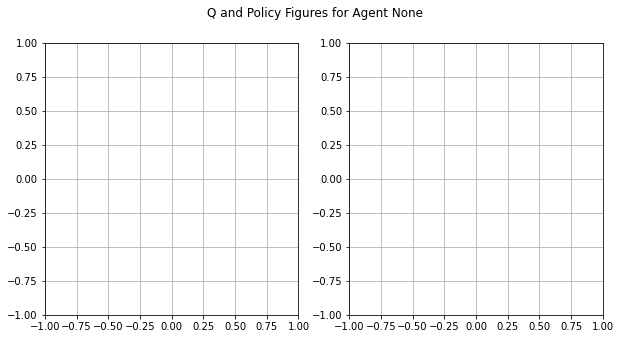

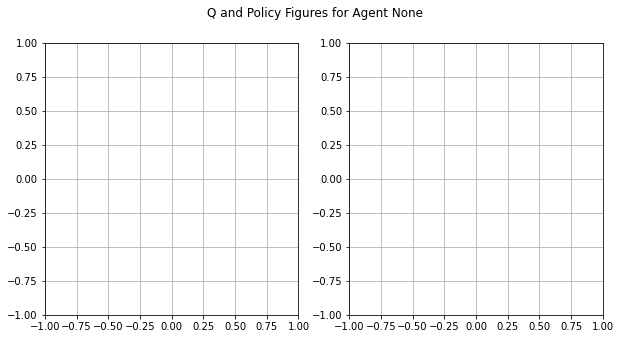

In [38]:
with U.single_threaded_session():
    for i, model_name in enumerate(model_names):
        print(i, model_name)
        agent = masql_agent(model_name, i, env, M, u_range, base_kwargs, game_name=game_name)
        agents.append(agent)
    sampler.initialize(env, agents)

    for agent in agents:
        agent._init_training()
        gt.rename_root('MARLAlgorithm')
        gt.reset()
        gt.set_def_unique(False)
        initial_exploration_done = False
        # noise = .1
        noise = 1.
        alpha = .5


        for agent in agents:
            try:
                agent.policy.set_noise_level(noise)
            except:
                pass

        for epoch in gt.timed_for(range(base_kwargs['n_epochs'] + 1)):
            logger.push_prefix('Epoch #%d | ' % epoch)
            if epoch % 10 == 0:
                print(suffix)
            for t in range(base_kwargs['epoch_length']):
                # TODO.code consolidation: Add control interval to sampler
                if not initial_exploration_done:
                    if epoch >= 1000:
                        initial_exploration_done = True
                sampler.sample()
                # print('Sampling')
                if not initial_exploration_done:
                    continue
                gt.stamp('sample')
                # print('Sample Done')
                if epoch == base_kwargs['n_epochs']:
                    noise = 0.1

                    for agent in agents:
                        try:
                            agent.policy.set_noise_level(noise)
                        except:
                            pass
                    # alpha = .1
                if epoch > base_kwargs['n_epochs'] / 10:
                    noise = 0.1
                    for agent in agents:
                        try:
                            agent.policy.set_noise_level(noise)
                        except:
                            pass
                    # alpha = .1
                if epoch > base_kwargs['n_epochs'] / 5:
                    noise = 0.05
                    for agent in agents:
                        try:
                            agent.policy.set_noise_level(noise)
                        except:
                            pass
                if epoch > base_kwargs['n_epochs'] / 6:
                    noise = 0.01
                    for agent in agents:
                        try:
                            agent.policy.set_noise_level(noise)
                        except:
                            pass

                for j in range(base_kwargs['n_train_repeat']):
                    batch_n = []
                    recent_batch_n = []
                    indices = None
                    receent_indices = None
                    for i, agent in enumerate(agents):
                        if i == 0:
                            batch = agent.pool.random_batch(batch_size)
                            indices = agent.pool.indices
                            receent_indices = list(range(agent.pool._top-batch_size, agent.pool._top))

                        batch_n.append(agent.pool.random_batch_by_indices(indices))
                        recent_batch_n.append(agent.pool.random_batch_by_indices(receent_indices))

                    # print(len(batch_n))
                    target_next_actions_n = []
                    try:
                        for agent, batch in zip(agents, batch_n):
                            target_next_actions_n.append(agent._target_policy.get_actions(batch['next_observations']))
                    except:
                        pass


                    opponent_actions_n = np.array([batch['actions'] for batch in batch_n])
                    recent_opponent_actions_n = np.array([batch['actions'] for batch in recent_batch_n])

                    ####### figure out
                    recent_opponent_observations_n = []
                    for batch in recent_batch_n:
                        recent_opponent_observations_n.append(batch['observations'])


                    current_actions = [agents[i]._policy.get_actions(batch_n[i]['next_observations'])[0][0] for i in range(agent_num)]
                    all_actions_k = []
                    with open('{}/policy.csv'.format(policy_dir), 'a') as f:
                        f.write(','.join(list(map(str, current_actions)))+'\n')
                    for i, agent in enumerate(agents):
                        try:
                            batch_n[i]['next_actions'] = deepcopy(target_next_actions_n[i])
                        except:
                            pass
                        batch_n[i]['opponent_actions'] = np.reshape(np.delete(deepcopy(opponent_actions_n), i, 0), (-1, agent._opponent_action_dim))
                        if agent.joint:
                            if agent.opponent_modelling:
                                batch_n[i]['recent_opponent_observations'] = recent_opponent_observations_n[i]
                                batch_n[i]['recent_opponent_actions'] = np.reshape(np.delete(deepcopy(recent_opponent_actions_n), i, 0), (-1, agent._opponent_action_dim))
                                batch_n[i]['opponent_next_actions'] = agent.opponent_policy.get_actions(batch_n[i]['next_observations'])
                            else:
                                batch_n[i]['opponent_next_actions'] = np.reshape(np.delete(deepcopy(target_next_actions_n), i, 0), (-1, agent._opponent_action_dim))
                       
                            agent._do_training(iteration=t + epoch * agent._epoch_length, batch=batch_n[i], annealing=alpha)
                 
                gt.stamp('train')


True arglist.aux
diff-ma_softq/2/MASQL_MASQL_MASQL_MASQL_MASQL_MASQL_MASQL_MASQL_MASQL_MASQL/2021-07-16 12:33:34.617981 
0 1
stochastic 1.0 True <function tanh at 0x7f29f48e7d90>
stochastic 1.0 True <function tanh at 0x7f29f48e7d90>
1 1
stochastic 1.0 True <function tanh at 0x7f29f48e7d90>
stochastic 1.0 True <function tanh at 0x7f29f48e7d90>


AssertionError: 

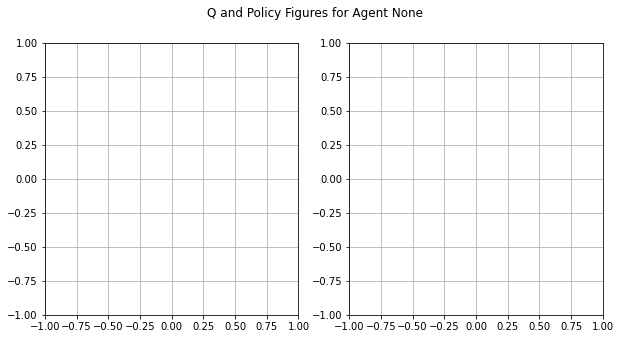

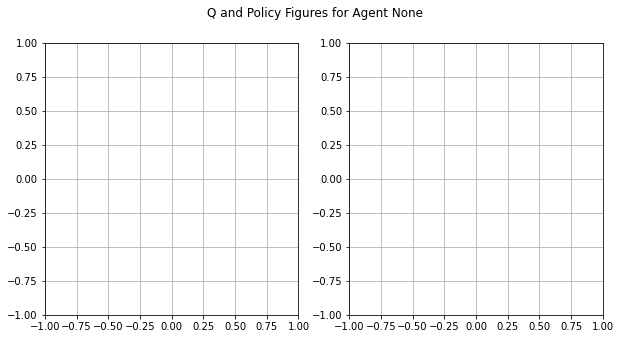

In [37]:
def main(arglist):
    game_name = arglist.game_name
    # 'abs', 'one'
    reward_type = arglist.reward_type
    p = arglist.p
    agent_num = arglist.n
    u_range = 1.
    k = 0
    print(arglist.aux, 'arglist.aux')
    model_names_setting = arglist.model_names_setting.split('_')
    model_names = [model_names_setting[0]] + [model_names_setting[1]] * (agent_num - 1)
    model_name = '_'.join(model_names)
    path_prefix = game_name
    if game_name == 'pbeauty':
        env = PBeautyGame(agent_num=agent_num, reward_type=reward_type, p=p)
        path_prefix  = game_name + '-' + reward_type + '-' + str(p)

    elif 'diff' in game_name:
        diff_game_name = game_name.split('-')[-1]
        agent_num = 2
        env = DifferentialGame(diff_game_name, agent_num)

    now = datetime.datetime.now()
    timestamp = now.strftime('%Y-%m-%d %H:%M:%S.%f %Z')
    if 'CG' in model_name:
        model_name = model_name + '-{}'.format(arglist.mu)
    if not arglist.aux:
        model_name = model_name + '-{}'.format(arglist.aux)

    suffix = '{}/{}/{}/{}'.format(path_prefix, agent_num, model_name, timestamp)

    print(suffix)

    logger.add_tabular_output('./log/{}.csv'.format(suffix))
    snapshot_dir = './snapshot/{}'.format(suffix)
    policy_dir = './policy/{}'.format(suffix)
    os.makedirs(snapshot_dir, exist_ok=True)
    os.makedirs(policy_dir, exist_ok=True)
    logger.set_snapshot_dir(snapshot_dir)

    agents = []
    M = arglist.hidden_size
    batch_size = arglist.batch_size
    sampler = MASampler(agent_num=agent_num, joint=True, max_path_length=30, min_pool_size=100, batch_size=batch_size)

    base_kwargs = {
        'sampler': sampler,
        'epoch_length': 1,
        'n_epochs': arglist.max_steps,
        'n_train_repeat': 1,
        'eval_render': True,
        'eval_n_episodes': 10
    }

    with U.single_threaded_session():
        for i, model_name in enumerate(model_names):
            if 'PR2AC' in model_name:
                pass
            elif model_name == 'MASQL':
                agent = masql_agent(model_name, i, env, M, u_range, base_kwargs, game_name=game_name)
            else:
                pass
            agents.append(agent)

        sampler.initialize(env, agents)

        for agent in agents:
            agent._init_training()
        gt.rename_root('MARLAlgorithm')
        gt.reset()
        gt.set_def_unique(False)
        initial_exploration_done = False
        # noise = .1
        noise = 1.
        alpha = .5


        for agent in agents:
            try:
                agent.policy.set_noise_level(noise)
            except:
                pass

        for epoch in gt.timed_for(range(base_kwargs['n_epochs'] + 1)):
            logger.push_prefix('Epoch #%d | ' % epoch)
            if epoch % 1 == 0:
                print(suffix)
            for t in range(base_kwargs['epoch_length']):
                # TODO.code consolidation: Add control interval to sampler
                if not initial_exploration_done:
                    if epoch >= 20:
                        initial_exploration_done = True
                sampler.sample()
                # print('Sampling')
                if not initial_exploration_done:
                    continue
                gt.stamp('sample')
                # print('Sample Done')
                if epoch == base_kwargs['n_epochs']:
                    noise = 0.1

                    for agent in agents:
                        try:
                            agent.policy.set_noise_level(noise)
                        except:
                            pass
                    # alpha = .1
                if epoch > base_kwargs['n_epochs'] / 10:
                    noise = 0.1
                    for agent in agents:
                        try:
                            agent.policy.set_noise_level(noise)
                        except:
                            pass
                    # alpha = .1
                if epoch > base_kwargs['n_epochs'] / 5:
                    noise = 0.05
                    for agent in agents:
                        try:
                            agent.policy.set_noise_level(noise)
                        except:
                            pass
                if epoch > base_kwargs['n_epochs'] / 6:
                    noise = 0.01
                    for agent in agents:
                        try:
                            agent.policy.set_noise_level(noise)
                        except:
                            pass

                for j in range(base_kwargs['n_train_repeat']):
                    batch_n = []
                    recent_batch_n = []
                    indices = None
                    receent_indices = None
                    for i, agent in enumerate(agents):
                        if i == 0:
                            batch = agent.pool.random_batch(batch_size)
                            indices = agent.pool.indices
                            receent_indices = list(range(agent.pool._top-batch_size, agent.pool._top))

                        batch_n.append(agent.pool.random_batch_by_indices(indices))
                        recent_batch_n.append(agent.pool.random_batch_by_indices(receent_indices))

                    # print(len(batch_n))
                    target_next_actions_n = []
                    try:
                        for agent, batch in zip(agents, batch_n):
                            target_next_actions_n.append(agent._target_policy.get_actions(batch['next_observations']))
                    except:
                        pass


                    opponent_actions_n = np.array([batch['actions'] for batch in batch_n])
                    recent_opponent_actions_n = np.array([batch['actions'] for batch in recent_batch_n])

                    ####### figure out
                    recent_opponent_observations_n = []
                    for batch in recent_batch_n:
                        print(batch['observations'].shape)
                        recent_opponent_observations_n.append(batch['observations'])


                    current_actions = [agents[i]._policy.get_actions(batch_n[i]['next_observations'])[0][0] for i in range(agent_num)]
                    all_actions_k = []
                    for i, agent in enumerate(agents):
                        if isinstance(agent, MAVBAC):
                            if agent._k > 0:
                                batch_actions_k = agent._policy.get_all_actions(batch_n[i]['next_observations'])
                                actions_k = [a[0][0] for a in batch_actions_k]
                                all_actions_k.append(';'.join(list(map(str, actions_k))))
                    if len(all_actions_k) > 0:
                        with open('{}/all_actions.csv'.format(policy_dir), 'a') as f:
                            f.write(','.join(list(map(str, all_actions_k))) + '\n')
                    with open('{}/policy.csv'.format(policy_dir), 'a') as f:
                        f.write(','.join(list(map(str, current_actions)))+'\n')
                    # print('============')
                    for i, agent in enumerate(agents):
                        try:
                            batch_n[i]['next_actions'] = deepcopy(target_next_actions_n[i])
                        except:
                            pass
                        batch_n[i]['opponent_actions'] = np.reshape(np.delete(deepcopy(opponent_actions_n), i, 0), (-1, agent._opponent_action_dim))
                        if agent.joint:
                            if agent.opponent_modelling:
                                batch_n[i]['recent_opponent_observations'] = recent_opponent_observations_n[i]
                                batch_n[i]['recent_opponent_actions'] = np.reshape(np.delete(deepcopy(recent_opponent_actions_n), i, 0), (-1, agent._opponent_action_dim))
                                batch_n[i]['opponent_next_actions'] = agent.opponent_policy.get_actions(batch_n[i]['next_observations'])
                            else:
                                batch_n[i]['opponent_next_actions'] = np.reshape(np.delete(deepcopy(target_next_actions_n), i, 0), (-1, agent._opponent_action_dim))
                        if isinstance(agent, MAVBAC) or isinstance(agent, MASQL):
                            agent._do_training(iteration=t + epoch * agent._epoch_length, batch=batch_n[i], annealing=alpha)
                        else:
                            agent._do_training(iteration=t + epoch * agent._epoch_length, batch=batch_n[i])
                gt.stamp('train')


            # #self._evaluate(epoch)

            # for agent in agents:
            #     params = agent.get_snapshot(epoch)
            #     logger.save_itr_params(epoch, params)
            # times_itrs = gt.get_times().stamps.itrs
            
            # eval_time = times_itrs['eval'][-1] if epoch > 1 else 0
            # total_time = gt.get_times().total
            # logger.record_tabular('time-train', times_itrs['train'][-1])
            # logger.record_tabular('time-eval', eval_time)
            # logger.record_tabular('time-sample', times_itrs['sample'][-1])
            # logger.record_tabular('time-total', total_time)
            # logger.record_tabular('epoch', epoch)

            # sampler.log_diagnostics()

            # logger.dump_tabular(with_prefix=False)
            # logger.pop_prefix()
            # sampler.terminate()




main(arglist)